# Masterthesis
#### Julian Jetz

In [1]:
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import stats
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix
from currency_converter import CurrencyConverter
from datetime import date


In [2]:
na_values = ['nan', 'N/A', 'NaN', 'NaT']

In [3]:
def get_merged_csv(flist, **kwargs):
    return pd.concat([pd.read_csv(f, **kwargs) for f in flist], ignore_index=True)

In [4]:
df = get_merged_csv(glob.glob('csvfiles/*.csv'), na_values=na_values, index_col=False, dtype = {"TYPE" : "str", "TYPEQ" : "str", "TYPTRK" : "str", "WEATHER" : "str", "VISIBLTY" : "str"})
df.shape[0]

/Users/julianjetz/anaconda3/envs/masterthesis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (119) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/julianjetz/anaconda3/envs/masterthesis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (119,128,129,130,131,132,133,134,135) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/julianjetz/anaconda3/envs/masterthesis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (7,27,41,119,125,126,127,128,129,130,131,132,133,134,135) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


62846

In [5]:
def getEuro(damage, year, month, day):
    c = CurrencyConverter(fallback_on_missing_rate=True)
    damage=c.convert(damage, 'USD', 'EUR', date=date(year, month, day))
    return damage

#### Schaden in Euro umwandeln

In [6]:
#df['ACCDMG'] = df.apply(lambda row : getEuro(row['ACCDMG'], row['YEAR4'], row['MONTH'], row['DAY']), axis=1)

In [7]:
def isSerious(accdmg, killed, injured):
    type="Not Significant"
    # killed=row['RREMPKLD']+row['PASSKLD']+row['OTHERKLD']
    # injured=row['RREMPINJ']+row['PASSINJ']+row['OTHERINJ']
    if accdmg>=150000 or injured > 0 or killed > 0:
        type="Significant"
    return type

#### Bestimmung der Schwere des Unfalls (Nicht Signifikant, Signifikant und Schwer)

In [8]:
df['ACCTYPE'] = df.apply(lambda row : isSerious(row['ACCDMG'],row['RREMPKLD'] + row['PASSKLD'] + row['OTHERKLD'],row['RREMPINJ'] + row['PASSINJ'] + row['OTHERINJ']), axis=1)

*Umwandlung Monat zu Jahreszeiten*
*TODO*

In [9]:
df['ACCTYPE'].unique()

array(['Not Significant', 'Significant'], dtype=object)

In [53]:
pd.set_option('display.max_columns', 500)
#df.head(50)

#### Entfernung aller n/a Werte

In [11]:
df=df.dropna(subset=['YEAR4', 'MONTH', 'TYPE', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOADF2', 'EMPTYF2', 'TONS', 'TYPEQ', 'TYPTRK', 'TEMP', 'VISIBLTY', 'WEATHER', 'COUNTY', 'TRNSPD', 'ACCDMG', 'ACCAUSE']);

df.shape[0]


58228

#### Ausreißer entfernen

In [12]:
std_dev = 3
df = df[(np.abs(stats.zscore(df[['LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOADF2', 'EMPTYF2', 'TONS', 'TEMP', 'ACCDMG']])) < float(std_dev)).all(axis=1)]

In [13]:
df.drop(df.loc[df['ACCTYPE']=="Not Significant"].index, inplace=True)
df.shape[0]

7369

##### TODO: Prüfen Adaptive Learning rate

#### [Adam Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) <br>
Die Adam-Optimierung ist eine stochastische Gradientenabsenkungsmethode, die auf einer adaptiven Schätzung von Momenten erster und zweiter Ordnung basiert. Das Verfahren ist "recheneffizient, hat wenig Speicherbedarf, ist invariant gegenüber der diagonalen Neuskalierung von Gradienten und eignet sich gut für Probleme, die in Bezug auf Daten/Parameter groß sind".
[Arxiv](https://arxiv.org/pdf/1412.6980.pdf)<br><br>
*Learning rate:* In der maschinellen Lern- und Statistiktechnik ist die Lernrate ein Tuningparameter in einem Optimierungsalgorithmus, der die Schrittweite bei jeder Iteration bestimmt und sich dabei auf ein Minimum einer Verlustfunktion zubewegt. Da sie beeinflusst, inwieweit neu gewonnene Informationen alte Informationen übersteuern, stellt sie metaphorisch die Geschwindigkeit dar, mit der ein maschinelles Lernmodell "lernt". Bei der Festlegung einer Lernrate gibt es einen Kompromiss zwischen der Konvergenzrate und der Überschreitung. Während die Richtung zum Minimum in der Regel aus dem Gradienten der Verlustfunktion bestimmt wird, bestimmt die Lernrate, wie groß ein Schritt in diese Richtung ist.Eine zu hohe Lernrate führt dazu, dass der Lernsprung über Minima hinausgeht, aber eine zu niedrige Lernrate dauert entweder zu lange, um sich zu konvergieren oder in einem unerwünschten lokalen Minimum stecken zu bleiben.


In [14]:
opti = tf.optimizers.Adam(learning_rate = 0.001)

#### [Nadam Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam?authuser=2&hl=vi&version=stable)
[Incorporating Nesterov Momentum into Adam](http://cs229.stanford.edu/proj2015/054_report.pdf)

In [15]:
# opti = tf.optimizers.Nadam(learning_rate = 0.01)

#### [Adagrad Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?hl=vi&authuser=2&version=stable)
Adagrad ist ein Optimierer mit parameter-spezifischen Lernraten, die angepasst werden, je nachdem, wie häufig ein Parameter während des Trainings aktualisiert wird. Je mehr Updates ein Parameter erhält, desto kleiner sind die Updates. [Adaptive Subgradient Methods for Online Learning and Stochastic Optimization](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

In [16]:
#opti = tf.optimizers.Adagrad(learning_rate = 0.001)

#### [Adamax Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adamax?hl=vi&authuser=2&version=stable)
Adamax ist eine Variante von Adam, die auf der Unendlichkeitsnorm basiert. Adamax ist Adam manchmal überlegen, besonders bei Modellen mit Einbettungen. [Arxiv](https://arxiv.org/pdf/1412.6980.pdf)

In [17]:
# opti = tf.optimizers.Adamax(learning_rate = 0.01)

## Complete regression model

Festlegen der abhängigen Variablen X und der vorherzusagenden Variable y

In [18]:
x_data = df[['YEAR4', 'MONTH', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOADF2', 'EMPTYF2', 'TONS', 'TEMP', 'TRNSPD', 'ACCAUSE', 'TYPE', 'TYPEQ', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'COUNTY']]
y = df['ACCDMG']

In [19]:
#x_data = df[df['ACCTYPE']=="Significant"][['YEAR4', 'MONTH', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOADF2',  'EMPTYF2', 'TONS', 'TEMP', 'TRNSPD', 'ACCAUSE', 'TYPE', 'TYPEQ', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'COUNTY']].copy()
#y = df[df['ACCTYPE']=="Significant"][['ACCDMG']].copy()

In [20]:
#cause_dummies= pd.get_dummies(df['ACCAUSE'], prefix='cause')
#x_data = pd.concat([x_data, df[['ACCAUSE', 'TYPE', 'TYPEQ', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'COUNTY']], axis=1)

In [21]:
x_data.describe(include='all')

,YEAR4,MONTH,LOADF1,LOADP1,EMPTYF1,EMPTYP1,LOADF2,EMPTYF2,TONS,TEMP,TRNSPD,ACCAUSE,TYPE,TYPEQ,TYPTRK,VISIBLTY,WEATHER,COUNTY
count,7369.000000,7369.000000,7369.000000,7369.000000,7369.000000,7369.000000,7369.000000,7369.000000,7369.000000,7369.000000,7369.000000,7369,7369,7369,7369,7369,7369,7369
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,299,13,14,4,4,6,1093
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M302,01,1,1,2,1,JEFFERSON
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,726,3946,4821,4722,3958,4979,179
mean,2008.946533,6.500204,41.428959,0.206270,15.014927,0.016013,2.823992,0.900122,4881.918442,60.283756,21.256616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.721492,3.332918,36.772061,0.905742,22.242331,0.194283,3.769821,1.962892,4806.668845,22.166253,19.350262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2004.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2008.000000,7.000000,35.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3969.000000,63.000000,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2014.000000,9.000000,69.000000,0.000000,23.000000,0.000000,5.000000,1.000000,7820.000000,78.000000,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
y.describe(include='all')

count    7.369000e+03
mean     2.734061e+05
std      2.707680e+05
min      6.600000e+03
25%      6.800000e+04
50%      2.031000e+05
75%      3.521700e+05
max      1.549000e+06
Name: ACCDMG, dtype: float64

#### Scattermatrix und Korrelationen der Daten
Jahr, Monat, Anzahl der beladenen Frachtwagons und Personenwagons, Gewicht, Temperatur, Geschwindigkeit und Unfallkosten

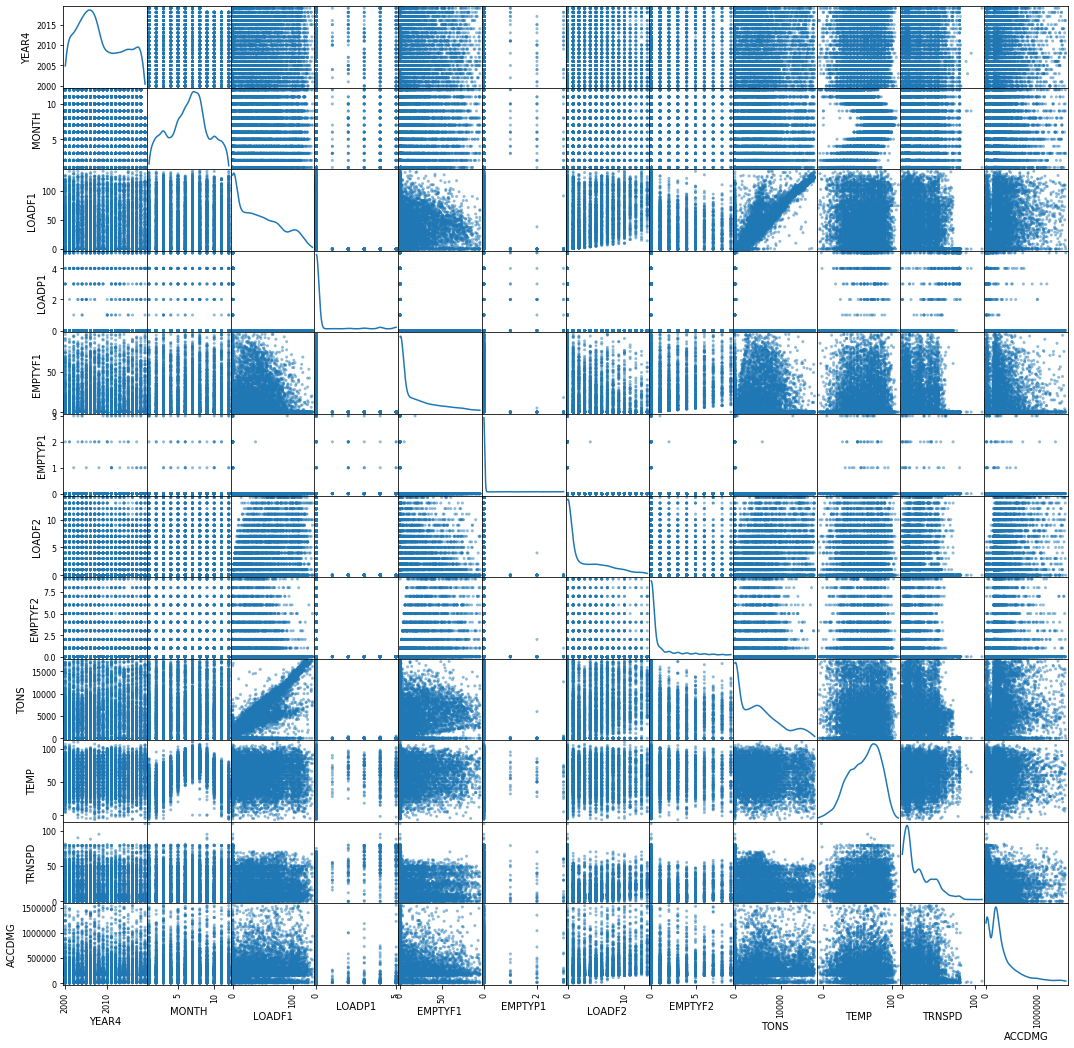

In [23]:
scatter_matrix(df[df['ACCTYPE']=="Significant"][['YEAR4', 'MONTH', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOADF2', 'EMPTYF2', 'TONS', 'TEMP', 'TRNSPD', 'ACCAUSE', 'TYPE', 'TYPEQ', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'COUNTY', 'ACCDMG']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"Images/scatterALL.png")

In [24]:
colormap = plt.cm.RdBu
corr = df[df['ACCTYPE']=="Significant"][['ACCDMG', 'YEAR4', 'MONTH', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOADF2', 'EMPTYF2', 'TONS', 'TEMP', 'TRNSPD', 'ACCAUSE', 'TYPE', 'TYPEQ', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'COUNTY']].corr()
corr

,ACCDMG,YEAR4,MONTH,LOADF1,LOADP1,EMPTYF1,EMPTYP1,LOADF2,EMPTYF2,TONS,TEMP,TRNSPD
ACCDMG,1.000000,0.029420,-0.023109,0.223732,-0.135367,0.024573,0.005609,0.431154,0.137717,0.224303,-0.076083,-0.106366
YEAR4,0.029420,1.000000,-0.057329,-0.000491,0.022661,0.006806,0.021649,-0.069477,-0.002953,0.003112,0.026234,-0.087498
MONTH,-0.023109,-0.057329,1.000000,0.007845,-0.016019,0.014914,-0.013629,-0.016584,-0.004851,0.007140,0.175649,0.003820
LOADF1,0.223732,-0.000491,0.007845,1.000000,-0.256603,-0.102779,-0.086223,0.458530,-0.086511,0.851042,-0.036984,-0.008835
LOADP1,-0.135367,0.022661,-0.016019,-0.256603,1.000000,-0.153756,0.073781,-0.170621,-0.104447,-0.230851,0.021718,0.425441
EMPTYF1,0.024573,0.006806,0.014914,-0.102779,-0.153756,1.000000,-0.053637,-0.063688,0.417811,0.049352,0.000206,-0.055779
EMPTYP1,0.005609,0.021649,-0.013629,-0.086223,0.073781,-0.053637,1.000000,-0.060268,-0.035310,-0.076032,-0.017979,0.013636
LOADF2,0.431154,-0.069477,-0.016584,0.458530,-0.170621,-0.063688,-0.060268,1.000000,0.028474,0.430027,-0.080560,-0.091434
EMPTYF2,0.137717,-0.002953,-0.004851,-0.086511,-0.104447,0.417811,-0.035310,0.028474,1.000000,-0.028571,-0.033203,-0.114481
TONS,0.224303,0.003112,0.007140,0.851042,-0.230851,0.049352,-0.076032,0.430027,-0.028571,1.000000,-0.046688,-0.003094


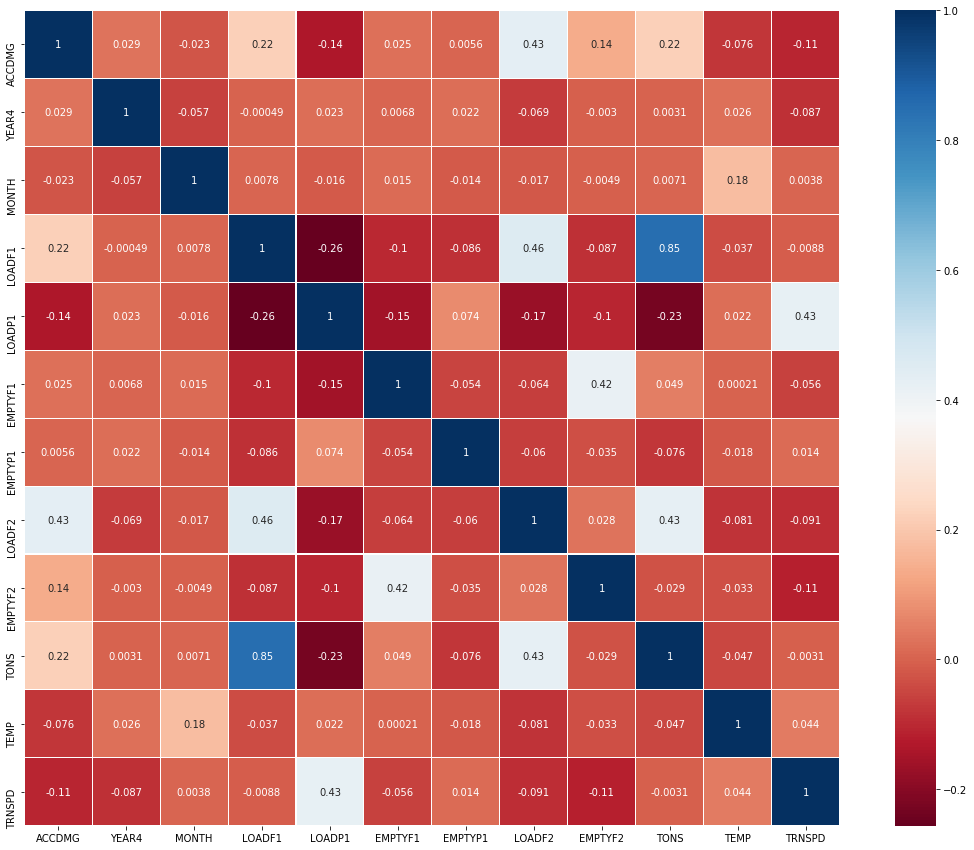

In [25]:
ax=plt.figure(figsize=(20,15)).gca()
sns.heatmap(corr,ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"Images/corrALL.png")

#### Aufteilen der Daten in Train und Test Datensatz

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.3)

#### Festlegen der numerischen Merkmalsspalten

In [27]:
trnspd = tf.feature_column.numeric_column('TRNSPD')
year = tf.feature_column.numeric_column('YEAR4')
month = tf.feature_column.numeric_column('MONTH')
loadf1 = tf.feature_column.numeric_column('LOADF1')
loadp1 = tf.feature_column.numeric_column('LOADP1')
emptyf1 = tf.feature_column.numeric_column('EMPTYF1')
emptyp1 = tf.feature_column.numeric_column('EMPTYP1')
loadf2 = tf.feature_column.numeric_column('LOADF2')
emptyf2 = tf.feature_column.numeric_column('EMPTYF2')
tons = tf.feature_column.numeric_column('TONS')
temp = tf.feature_column.numeric_column('TEMP')

In [28]:
x_data[['ACCAUSE', 'TYPE', 'TYPEQ', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'COUNTY']].astype(str).values

array([['E53C', '01', '1', ..., '3', '1', 'TOOLE'],
       ['H524', '01', '1', ..., '4', '1', 'WARD'],
       ['M303', '07', '1', ..., '2', '1', 'BUTLER'],
       ...,
       ['M505', '07', '1', ..., '2', '1', 'WAYNE'],
       ['H503', '01', '1', ..., '4', '2', 'SWEETWATER'],
       ['E61C', '01', '1', ..., '2', '1', 'LARAMIE']], dtype=object)

#### Festlegen der kategorischen Merkmalsspalten. 
Anstatt die Daten als einen one-hot Vektor mit vielen Dimensionen darzustellen, stellt eine Einbettungsspalte diese Daten als einen niederdimensionalen, dichten Vektor dar, in dem jede Zelle eine beliebige Zahl enthalten kann, nicht nur 0 oder 1. Die Größe der Einbettung ist ein Parameter, der angepasst werden muss (*TODO*).

In [29]:
accause = tf.feature_column.categorical_column_with_hash_bucket('ACCAUSE',hash_bucket_size=10000)

embedding_size = int(math.floor(len(x_data['ACCAUSE'].unique())**0.25))
accause=tf.feature_column.embedding_column(accause, dimension=embedding_size)

In [30]:
acctype = tf.feature_column.categorical_column_with_hash_bucket('TYPE',hash_bucket_size=10000)

embedding_size = int(math.floor(len(x_data['TYPE'].unique())**0.25))
acctype=tf.feature_column.embedding_column(acctype, dimension=embedding_size)

In [31]:
typeq = tf.feature_column.categorical_column_with_hash_bucket('TYPEQ',hash_bucket_size=10000)

embedding_size = int(math.floor(len(x_data['TYPEQ'].unique())**0.25))
typeq=tf.feature_column.embedding_column(typeq, dimension=embedding_size)

In [32]:
typtrk = tf.feature_column.categorical_column_with_hash_bucket('TYPTRK',hash_bucket_size=10000)

embedding_size = int(math.floor(len(x_data['TYPTRK'].unique())**0.25))
typtrk=tf.feature_column.embedding_column(typtrk, dimension=embedding_size)

In [33]:
visibility = tf.feature_column.categorical_column_with_hash_bucket('VISIBLTY',hash_bucket_size=10000)

embedding_size = int(math.floor(len(x_data['VISIBLTY'].unique())**0.25))
visibility=tf.feature_column.embedding_column(visibility, dimension=embedding_size)

In [34]:
weather = tf.feature_column.categorical_column_with_hash_bucket('WEATHER',hash_bucket_size=10000)

embedding_size = int(math.floor(len(x_data['WEATHER'].unique())**0.25))
weather=tf.feature_column.embedding_column(weather, dimension=embedding_size)

In [35]:
county = tf.feature_column.categorical_column_with_hash_bucket('COUNTY',hash_bucket_size=10000)

embedding_size = int(math.floor(len(x_data['COUNTY'].unique())**0.25))
county=tf.feature_column.embedding_column(county, dimension=embedding_size)

#### Festlegen der Merkmalsspalten

In [36]:
feature_col =[year, month, trnspd, typeq, loadf1, loadp1, emptyf1, emptyp1, loadf2, emptyf2, typtrk, acctype, accause, visibility, weather, temp, county]

#### Aufstellen der Input Funktion

Batch_Size=Größe der zurückzusendenden Batches.<br>
Num_Epochs=Anzahl der Perioden, die man über Daten iterieren muss.<br>
Shuffle=Sollendie Datensätze in zufälliger Reihenfolge gelesen werden?

In [37]:
input_func= tf.compat.v1.estimator.inputs.pandas_input_fn(x=x_train, 
                                                y= y_train, 
                                                batch_size=10, 
                                                num_epochs=1000, 
                                                 shuffle=True)

#### Aufstellen der Eval Input Funktion

In [38]:
test_input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x=x_test,                                                   
                                                 batch_size=10, 
                                                 num_epochs=1, 
                                                 shuffle=False)
eval_input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x=x_test,
                                                      y=y_test, 
                                                      batch_size=10, 
                                                      num_epochs=1, 
                                                      shuffle=False)
train_input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x=x_train,                                                   
                                                 batch_size=10, 
                                                 num_epochs=1, 
                                                 shuffle=False)

#### Initialisierung des Estimators (DNNRegressor)
hidden_units=Das Argument hidden_units ermöglicht es, ein Array mit der Anzahl der Knoten für jede Schicht zu erzeugen. Dies ermöglicht es, ein neuronales Netzwerk zu erstellen, indem einfach seine Größe und Form berücksichtigt wird, anstatt das Ganze von Grund auf von Hand zu vernetzen. (TODO: fine tune)

In [39]:
estimator = tf.estimator.DNNRegressor(hidden_units=[15,30,45,30], feature_columns=feature_col, optimizer=opti, dropout=0.5)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/4y/xfd9r0rd0jz001c3ts8044dr0000gn/T/tmp3ey_f4mf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a4c0faf90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Train Model

In [40]:
estimator.train(input_fn=input_func, max_steps=60000)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/4y/xfd9r0rd0jz001c3ts8044dr0000gn/T/tmp3ey_f4mf/model.ckpt.
INFO:tensorflow:loss = 116689860000.0, step = 0
INFO:tensorflow:global_step/sec: 41.462
INFO:tensorflow:loss = 18

INFO:tensorflow:global_step/sec: 179.378
INFO:tensorflow:loss = 125470640000.0, step = 5500 (0.557 sec)
INFO:tensorflow:global_step/sec: 175.376
INFO:tensorflow:loss = 8998287000.0, step = 5600 (0.570 sec)
INFO:tensorflow:global_step/sec: 176.017
INFO:tensorflow:loss = 64780853000.0, step = 5700 (0.568 sec)
INFO:tensorflow:global_step/sec: 178.319
INFO:tensorflow:loss = 110913410000.0, step = 5800 (0.560 sec)
INFO:tensorflow:global_step/sec: 179.224
INFO:tensorflow:loss = 33610547000.0, step = 5900 (0.558 sec)
INFO:tensorflow:global_step/sec: 172.683
INFO:tensorflow:loss = 218443580000.0, step = 6000 (0.579 sec)
INFO:tensorflow:global_step/sec: 178.722
INFO:tensorflow:loss = 18674270000.0, step = 6100 (0.560 sec)
INFO:tensorflow:global_step/sec: 173.604
INFO:tensorflow:loss = 59048026000.0, step = 6200 (0.575 sec)
INFO:tensorflow:global_step/sec: 178.157
INFO:tensorflow:loss = 102109440000.0, step = 6300 (0.561 sec)
INFO:tensorflow:global_step/sec: 179.734
INFO:tensorflow:loss = 346428

INFO:tensorflow:loss = 42320822000.0, step = 13400 (0.647 sec)
INFO:tensorflow:global_step/sec: 156.559
INFO:tensorflow:loss = 174239330000.0, step = 13500 (0.639 sec)
INFO:tensorflow:global_step/sec: 148.339
INFO:tensorflow:loss = 28143420000.0, step = 13600 (0.674 sec)
INFO:tensorflow:global_step/sec: 149.694
INFO:tensorflow:loss = 23973255000.0, step = 13700 (0.668 sec)
INFO:tensorflow:global_step/sec: 155.456
INFO:tensorflow:loss = 55297925000.0, step = 13800 (0.643 sec)
INFO:tensorflow:global_step/sec: 151.759
INFO:tensorflow:loss = 36479720000.0, step = 13900 (0.659 sec)
INFO:tensorflow:global_step/sec: 151.568
INFO:tensorflow:loss = 115979080000.0, step = 14000 (0.660 sec)
INFO:tensorflow:global_step/sec: 151.224
INFO:tensorflow:loss = 71238330000.0, step = 14100 (0.661 sec)
INFO:tensorflow:global_step/sec: 149.193
INFO:tensorflow:loss = 157703930000.0, step = 14200 (0.670 sec)
INFO:tensorflow:global_step/sec: 151.79
INFO:tensorflow:loss = 31421550000.0, step = 14300 (0.659 sec)

INFO:tensorflow:loss = 64011510000.0, step = 21300 (0.629 sec)
INFO:tensorflow:global_step/sec: 158.621
INFO:tensorflow:loss = 89268590000.0, step = 21400 (0.630 sec)
INFO:tensorflow:global_step/sec: 163.723
INFO:tensorflow:loss = 24790920000.0, step = 21500 (0.611 sec)
INFO:tensorflow:global_step/sec: 167.174
INFO:tensorflow:loss = 46329260000.0, step = 21600 (0.598 sec)
INFO:tensorflow:global_step/sec: 167.831
INFO:tensorflow:loss = 159994180000.0, step = 21700 (0.596 sec)
INFO:tensorflow:global_step/sec: 171.757
INFO:tensorflow:loss = 42674350000.0, step = 21800 (0.582 sec)
INFO:tensorflow:global_step/sec: 169.54
INFO:tensorflow:loss = 13043640000.0, step = 21900 (0.590 sec)
INFO:tensorflow:global_step/sec: 172.286
INFO:tensorflow:loss = 148946440000.0, step = 22000 (0.581 sec)
INFO:tensorflow:global_step/sec: 174.493
INFO:tensorflow:loss = 23040465000.0, step = 22100 (0.573 sec)
INFO:tensorflow:global_step/sec: 176.105
INFO:tensorflow:loss = 11314529000.0, step = 22200 (0.568 sec)


INFO:tensorflow:loss = 10007190000.0, step = 29200 (0.570 sec)
INFO:tensorflow:global_step/sec: 178.518
INFO:tensorflow:loss = 24253934000.0, step = 29300 (0.560 sec)
INFO:tensorflow:global_step/sec: 179.269
INFO:tensorflow:loss = 76334780000.0, step = 29400 (0.558 sec)
INFO:tensorflow:global_step/sec: 175.989
INFO:tensorflow:loss = 34897895000.0, step = 29500 (0.568 sec)
INFO:tensorflow:global_step/sec: 168.618
INFO:tensorflow:loss = 97285300000.0, step = 29600 (0.593 sec)
INFO:tensorflow:global_step/sec: 172.064
INFO:tensorflow:loss = 19774990000.0, step = 29700 (0.581 sec)
INFO:tensorflow:global_step/sec: 169.892
INFO:tensorflow:loss = 22547395000.0, step = 29800 (0.589 sec)
INFO:tensorflow:global_step/sec: 172.107
INFO:tensorflow:loss = 32496445000.0, step = 29900 (0.581 sec)
INFO:tensorflow:global_step/sec: 169.871
INFO:tensorflow:loss = 50721830000.0, step = 30000 (0.589 sec)
INFO:tensorflow:global_step/sec: 163.195
INFO:tensorflow:loss = 109979020000.0, step = 30100 (0.613 sec)


INFO:tensorflow:loss = 192282460000.0, step = 37100 (0.610 sec)
INFO:tensorflow:global_step/sec: 165.862
INFO:tensorflow:loss = 6299480000.0, step = 37200 (0.602 sec)
INFO:tensorflow:global_step/sec: 167.088
INFO:tensorflow:loss = 25975171000.0, step = 37300 (0.599 sec)
INFO:tensorflow:global_step/sec: 173.295
INFO:tensorflow:loss = 41482318000.0, step = 37400 (0.577 sec)
INFO:tensorflow:global_step/sec: 173.869
INFO:tensorflow:loss = 54104910000.0, step = 37500 (0.575 sec)
INFO:tensorflow:global_step/sec: 170.709
INFO:tensorflow:loss = 169496720000.0, step = 37600 (0.586 sec)
INFO:tensorflow:global_step/sec: 191.106
INFO:tensorflow:loss = 40500482000.0, step = 37700 (0.523 sec)
INFO:tensorflow:global_step/sec: 190.328
INFO:tensorflow:loss = 17464185000.0, step = 37800 (0.525 sec)
INFO:tensorflow:global_step/sec: 177.632
INFO:tensorflow:loss = 48190403000.0, step = 37900 (0.563 sec)
INFO:tensorflow:global_step/sec: 177.348
INFO:tensorflow:loss = 186326480000.0, step = 38000 (0.564 sec)

INFO:tensorflow:loss = 86903290000.0, step = 45000 (0.656 sec)
INFO:tensorflow:global_step/sec: 156.576
INFO:tensorflow:loss = 20937080000.0, step = 45100 (0.639 sec)
INFO:tensorflow:global_step/sec: 158.884
INFO:tensorflow:loss = 16252084000.0, step = 45200 (0.630 sec)
INFO:tensorflow:global_step/sec: 163.591
INFO:tensorflow:loss = 43305886000.0, step = 45300 (0.611 sec)
INFO:tensorflow:global_step/sec: 167.84
INFO:tensorflow:loss = 102574670000.0, step = 45400 (0.596 sec)
INFO:tensorflow:global_step/sec: 169.852
INFO:tensorflow:loss = 24963076000.0, step = 45500 (0.589 sec)
INFO:tensorflow:global_step/sec: 170.147
INFO:tensorflow:loss = 68760600000.0, step = 45600 (0.588 sec)
INFO:tensorflow:global_step/sec: 173.229
INFO:tensorflow:loss = 34347045000.0, step = 45700 (0.577 sec)
INFO:tensorflow:global_step/sec: 176.153
INFO:tensorflow:loss = 6712233000.0, step = 45800 (0.568 sec)
INFO:tensorflow:global_step/sec: 174.234
INFO:tensorflow:loss = 92916860000.0, step = 45900 (0.574 sec)
IN

INFO:tensorflow:loss = 30331785000.0, step = 52900 (0.689 sec)
INFO:tensorflow:global_step/sec: 139.308
INFO:tensorflow:loss = 110159266000.0, step = 53000 (0.718 sec)
INFO:tensorflow:global_step/sec: 150.537
INFO:tensorflow:loss = 64706340000.0, step = 53100 (0.665 sec)
INFO:tensorflow:global_step/sec: 150.421
INFO:tensorflow:loss = 32340673000.0, step = 53200 (0.665 sec)
INFO:tensorflow:global_step/sec: 153.774
INFO:tensorflow:loss = 10613425000.0, step = 53300 (0.650 sec)
INFO:tensorflow:global_step/sec: 151.553
INFO:tensorflow:loss = 100648580000.0, step = 53400 (0.660 sec)
INFO:tensorflow:global_step/sec: 148.284
INFO:tensorflow:loss = 29781470000.0, step = 53500 (0.675 sec)
INFO:tensorflow:global_step/sec: 153.356
INFO:tensorflow:loss = 37336470000.0, step = 53600 (0.652 sec)
INFO:tensorflow:global_step/sec: 161.682
INFO:tensorflow:loss = 87815980000.0, step = 53700 (0.619 sec)
INFO:tensorflow:global_step/sec: 164.813
INFO:tensorflow:loss = 16532411000.0, step = 53800 (0.607 sec)

#### Evaluate Model mit Eval input function

In [41]:
result_eval = estimator.evaluate(input_fn=eval_input_func)
result_eval

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-02-24T01:13:39Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/4y/xfd9r0rd0jz001c3ts8044dr0000gn/T/tmp3ey_f4mf/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-02-24-01:13:41
INFO:tensorflow:Saving dict for global step 60000: average_loss = 89789200000.0, global_step = 60000, label/mean = 277476.5, loss = 89917840000.0, prediction/mean = 107580.1
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /var/folders/4y/xfd9r0rd0jz001c3ts8044dr0000gn/T/tmp3ey_f4mf/model.ckpt-60000


{'average_loss': 89789200000.0,
 'label/mean': 277476.5,
 'loss': 89917840000.0,
 'prediction/mean': 107580.1,
 'global_step': 60000}

#### Scatterplot Vergleich tatsächliche und vorhergesagte Werte

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/4y/xfd9r0rd0jz001c3ts8044dr0000gn/T/tmp3ey_f4mf/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0, 0.5, 'predicted values (test data)')

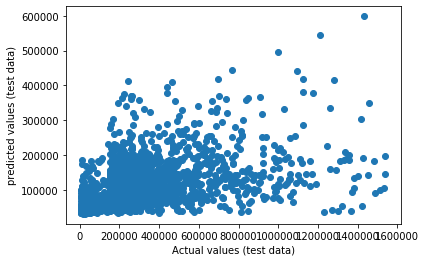

In [42]:
predictions=[]
for pred in estimator.predict(input_fn=test_input_func):
    predictions.append(pred['predictions'][0].astype(float))
plt.plot(y_test, predictions, 'o')
plt.xlabel('Actual values (test data)')
plt.ylabel('predicted values (test data)')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/4y/xfd9r0rd0jz001c3ts8044dr0000gn/T/tmp3ey_f4mf/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0, 0.5, 'predicted values (train data)')

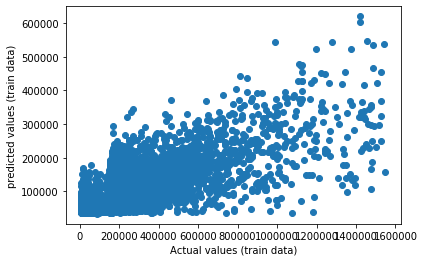

In [43]:
train_predictions=[]
for pred in estimator.predict(input_fn=train_input_func):
    train_predictions.append(pred['predictions'][0].astype(float))
plt.plot(y_train, train_predictions, 'o')
plt.xlabel('Actual values (train data)')
plt.ylabel('predicted values (train data)')

In [44]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))**0.5
rmse

547.4015540268514

#### Verleich tatsächliche und vorhergesagte Werte 
Beispiel: 30 zufällig ausgewählte Werte

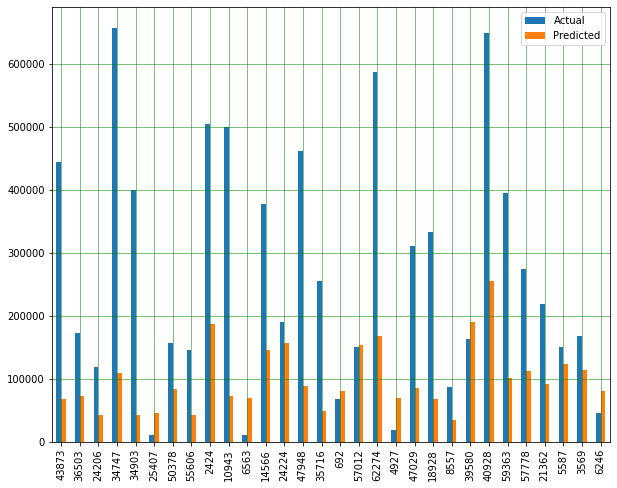

In [52]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
pred1 = pred.sample(30)

pred1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### Residual Plot 
Abweichung zwischen den vorhergesagten und tatsächlichen Unfallkosten (Testdaten=grün, Trainingsdaten=blau)

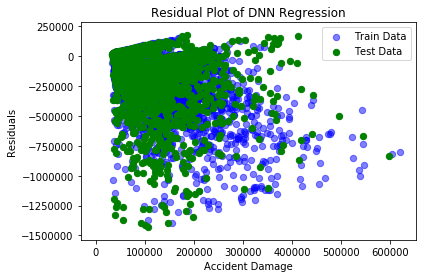

In [46]:
    plt.scatter(train_predictions, train_predictions - y_train, c='b', s=40, alpha=0.5, label='Train Data')
    plt.scatter(predictions, predictions - y_test, c='g', s=40, label='Test Data')
    plt.hlines(y=0, xmin=-0.03, xmax=0.2)
    plt.title('Residual Plot of DNN Regression')
    plt.ylabel('Residuals')
    plt.xlabel('Accident Damage')
    plt.legend()
    plt.show()